In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.nn.functional as F
import os
import datetime
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#Global Parameters and Variables loaded 
import config

if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

#empty cuda cache
torch.cuda.empty_cache()

# Models

In [2]:
class ResNetAutoencoder(nn.Module):
    def __init__(self,target_size=501):
        super(ResNetAutoencoder, self).__init__()

        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.target_size = target_size
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.adaptive_avg_pool2d(x, (128, self.target_size))  # adapt to target size
        return x





class FineTuneModel(nn.Module):
    def __init__(self, pretrained_autoencoder, num_classes):
        super(FineTuneModel, self).__init__()
        # Use the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))# for different input size

        # Classification head: Three fully connected layers
        #self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer
        #self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer
        #self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes

        self.fc1 = nn.Linear(2048, 512)  # First FC layer
        self.fc2 = nn.Linear(512, 256)   # Second FC layer
        self.fc3 = nn.Linear(256, num_classes)  # Output layer

        self.dropout = nn.Dropout(0.5)

        # Non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  
        return x
    

class FineTuneModelFREZ(nn.Module):
    def __init__(self, pretrained_autoencoder, num_classes):
        super(FineTuneModelFREZ, self).__init__()
        # Use the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder

        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head: Three fully connected layers
        #self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer
        #self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer
        #self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        # dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set here the Model that should be fintuned

In [3]:
#Pretrain_model_dir = "./results/res_auto/20231210-184529_auto"
Pretrain_model_dir = "./results/res_auto"

## Data


In [4]:
#------Datasplit
from Slit_and_validation_fun import *

train_df, test_df, val_df = train_test_ADSMI()

foldername = "RS96_15sec_batch32_7_50_masking_ref3"
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64


### Model initalisation

In [5]:
# Hyperparameters
num_epochs = config.finetune_epochs 
weight_decay = 0  # L2 regularization
batch_size = config.batch_size
patience = config.patience
# Specify learning rates
learning_rate_encoder = 0.0003
learning_rate_fc = 0.0005
learning_rate = learning_rate_encoder

# Number of classes
num_classes = len(set(labels_file["Label_int"]))  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Early stopping parameters
patience = config.patience 
early_stop_counter = 0



# Load the entire pre-trained model (from your contrastive training)
#pretrained_model = torch.load(Pretrain_model_dir + '/resNetTry23_11_autoen_model.pth')
pretrained_model = torch.load(Pretrain_model_dir + '/resNet_autoen_model.pth')

# Load the encoder from the pre-trained model
encoder_trained = pretrained_model.encoder

data1,_ = next(iter(train_loader))
target_size = data1.shape[3]
print(target_size)



    
# Initialize the FineTuneModel with the pre-trained encoder
model = FineTuneModel(pretrained_model, num_classes).to(device)
#model = FineTuneModelFREZ(pretrained_model, num_classes).to(device)


# Separate parameters of encoder and fully connected layers
encoder_params = model.encoder.parameters()
fc_params = list(model.fc1.parameters()) + list(model.fc2.parameters()) + list(model.fc3.parameters())

# Create parameter groups with different learning rates
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': learning_rate_encoder},
    {'params': fc_params, 'lr': learning_rate_fc}
])


938


In [6]:

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4 ) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) 

#Schedulers
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.6, verbose=True)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=5, mode='triangular')
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

#new folder path
finetune_results_dir = f'./finetune_results/FT_Autoencoder_ADSMI_{foldername}'#{num_epochs}_epochs_{datetime.datetime.now().strftime("%Y-%m-%d-%H")}'

# Create a new folder to save the results
if not os.path.exists(finetune_results_dir):
    os.makedirs(finetune_results_dir)

# create log file
with open(f'{finetune_results_dir}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'Finetuning on AUTOENCODER PRETRAIN{data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')


train_losses = []
val_losses = []
best_accuracy = 0
best_f1_macro_avg = 0
best_loss = 1000
early_stop_counter = 0
save_counter = 0
save_start = 0
#model_path = "./finetune_results/newgpulr0001_checkpoint.pth"

### Test plot datapoint

torch.Size([128, 938])
torch.Size([32, 3, 128, 938])


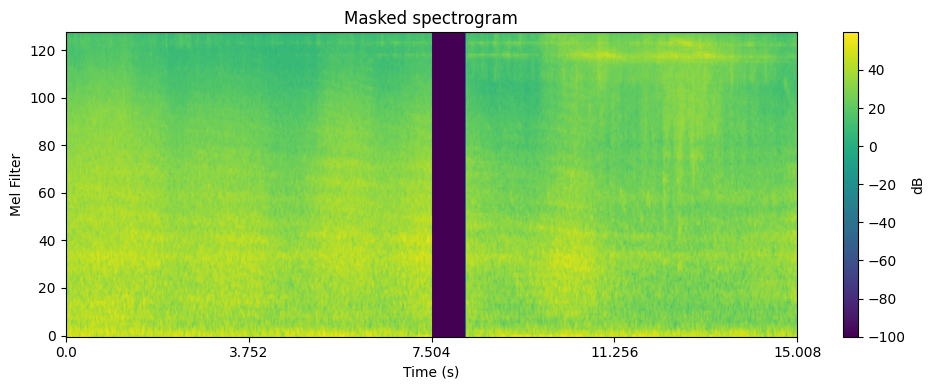

In [7]:
data1,_ = next(iter(train_loader))

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length, name):
    plt.figure(figsize=(10, 4))

    melspe_db_single = melspe_db[0, 0, :, :].squeeze()

    print(melspe_db_single.shape)
    print(melspe_db.shape)

    if melspe_db_single.ndim != 2:
        raise ValueError("melspe_db_single should be a 2D array")

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db_single.cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(name)

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), 
               np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Call the function with the modified data
plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")


In [8]:

from sklearn.metrics import f1_score as calculate_f1_score


for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    all_predicted = []
    all_labels = []
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy, loss, and now F1 score
    accuracy = correct_predictions / total_samples

    # Calculate macro avg f1 score using the alias
    f1_macro_avg = calculate_f1_score(all_labels, all_predicted, average='macro')

    if f1_macro_avg > best_f1_macro_avg and save_counter >= save_start:
        best_f1_macro_avg = f1_macro_avg
        torch.save(model, finetune_results_dir + '/checkpoint_best_f1.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best F1 Score improved on epoch {epoch}: {best_f1_macro_avg:.4f}\n")

    if correct_predictions / total_samples > best_accuracy and save_counter >= save_start:
        best_accuracy = accuracy
        torch.save(model, finetune_results_dir + '/checkpoint.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss and save_counter >= save_start:
        best_loss = avg_val_loss
        torch.save(model, finetune_results_dir + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    save_counter += 1
    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%", f"Val F1 Score: {f1_macro_avg:.4f}")
    with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')

  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')

### Losses Plot

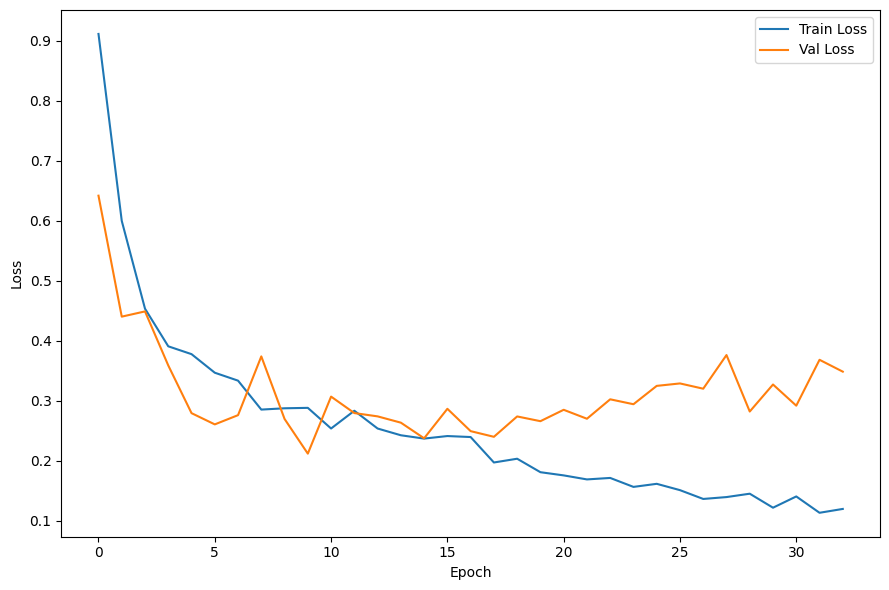

In [ ]:
# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(9, 6))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()


# Save the plot
plt.savefig(f'{finetune_results_dir}/loss_plot.png')

plt.show()

### Save Results of all 3 Modell Saves: Best-Val-Accuracy, Best-Val-loss and full model


Evaluation Results:
Balanced Accuracy2: 84.61%
Test Accuracy: 90.47%

Evaluation Results:
Accuracy: 90.47%
Precision: 87.82%
Recall: 84.61%
F1-score: 86.06%
Kappa: 84.88%
                         precision    recall  f1-score   support

            [Kreischen]     0.8922    0.9409    0.9159       220
[Kreischen][Quietschen]     0.8194    0.8194    0.8194        72
              [Negativ]     0.9679    0.9096    0.9379       166
           [Quietschen]     0.8333    0.7143    0.7692        14

               accuracy                         0.9047       472
              macro avg     0.8782    0.8461    0.8606       472
           weighted avg     0.9060    0.9047    0.9046       472



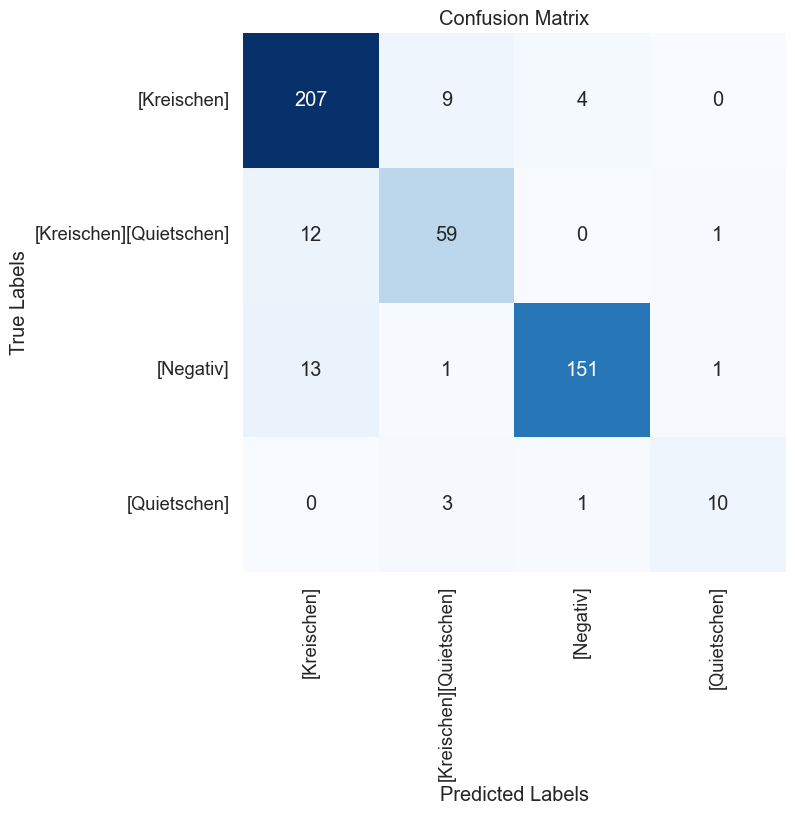

In [ ]:
validation_fun(finetune_results_dir,'/Full_model_checkpoint.pth',"full_model",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)




Evaluation Results:
Balanced Accuracy2: 85.70%
Test Accuracy: 90.25%

Evaluation Results:
Accuracy: 90.25%
Precision: 89.99%
Recall: 85.70%
F1-score: 87.37%
Kappa: 84.30%
                         precision    recall  f1-score   support

            [Kreischen]     0.8594    0.9727    0.9126       220
[Kreischen][Quietschen]     0.9091    0.6944    0.7874        72
              [Negativ]     0.9740    0.9036    0.9375       166
           [Quietschen]     0.8571    0.8571    0.8571        14

               accuracy                         0.9025       472
              macro avg     0.8999    0.8570    0.8737       472
           weighted avg     0.9072    0.9025    0.9006       472



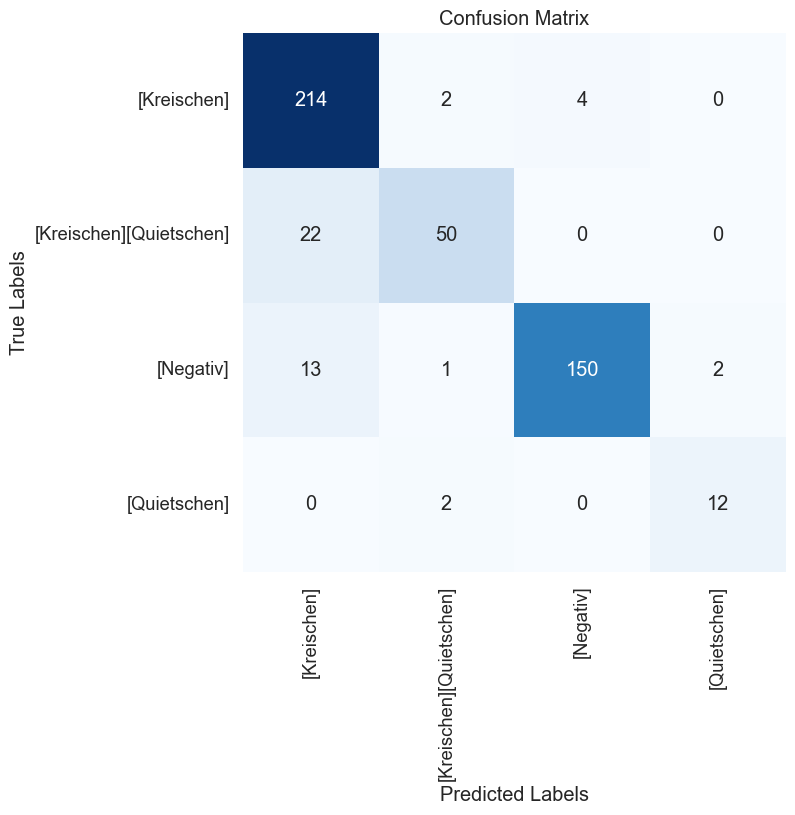

In [ ]:
validation_fun(finetune_results_dir,'/checkpoint_best_f1.pth',"f1_model",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)





Evaluation Results:
Balanced Accuracy2: 87.82%
Test Accuracy: 91.10%

Evaluation Results:
Accuracy: 91.10%
Precision: 89.53%
Recall: 87.82%
F1-score: 88.58%
Kappa: 85.84%
                         precision    recall  f1-score   support

            [Kreischen]     0.8861    0.9545    0.9190       220
[Kreischen][Quietschen]     0.8636    0.7917    0.8261        72
              [Negativ]     0.9742    0.9096    0.9408       166
           [Quietschen]     0.8571    0.8571    0.8571        14

               accuracy                         0.9110       472
              macro avg     0.8953    0.8782    0.8858       472
           weighted avg     0.9128    0.9110    0.9107       472



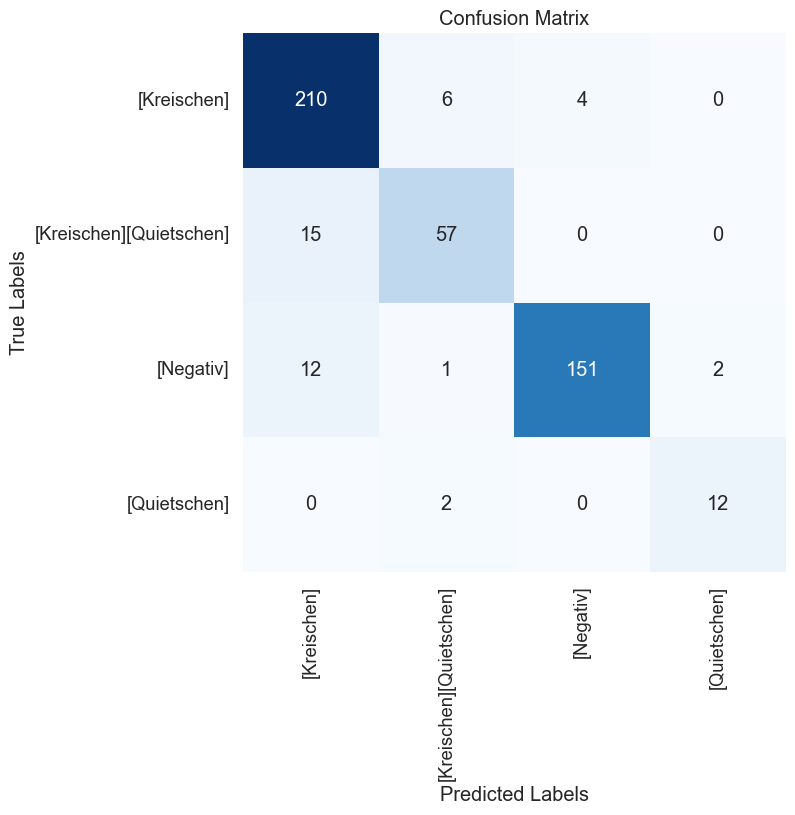

In [ ]:
validation_fun(finetune_results_dir,'/checkpoint.pth',"best_accuracy",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)



Evaluation Results:
Balanced Accuracy2: 87.72%
Test Accuracy: 89.83%

Evaluation Results:
Accuracy: 89.83%
Precision: 89.17%
Recall: 87.72%
F1-score: 88.41%
Kappa: 83.96%
                         precision    recall  f1-score   support

            [Kreischen]     0.8964    0.9045    0.9005       220
[Kreischen][Quietschen]     0.8082    0.8194    0.8138        72
              [Negativ]     0.9390    0.9277    0.9333       166
           [Quietschen]     0.9231    0.8571    0.8889        14

               accuracy                         0.8983       472
              macro avg     0.8917    0.8772    0.8841       472
           weighted avg     0.8987    0.8983    0.8985       472



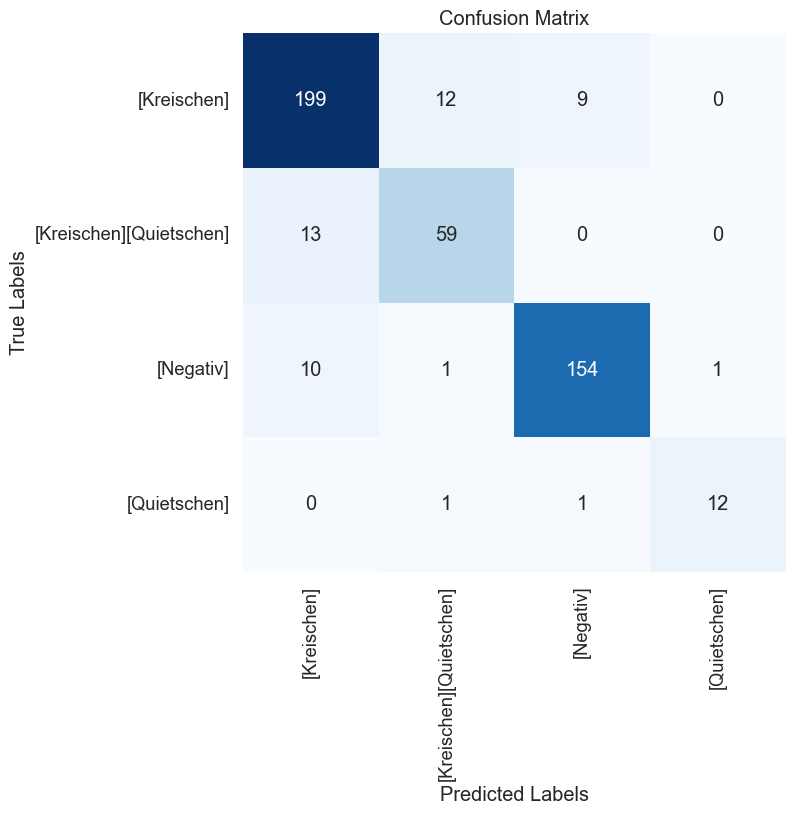

In [ ]:
validation_fun(finetune_results_dir,'/checkpoint_best_loss.pth',"best_loss",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)